In [2]:
from osgeo import gdal
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch import permute
from torch import nan_to_num
from torchvision.transforms import ToTensor
import rasterio
import numpy as np

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


In [4]:

import os
import random

def check_maskfolder(mask_folder):
    # List all GeoTIFF files in the mask folder
    tiff_files = [f for f in os.listdir(mask_folder) if f.lower().endswith((".tif", ".tiff"))]
    if not tiff_files:
        print("No TIFF files in folder:", mask_folder)
        return
    # Compute statistics for all TIFF files in the mask folder
    all_class_counts = {}
    total_pixels = 0
    shapes = []
    for tiff_file in tiff_files:
        tiff_path = os.path.join(mask_folder, tiff_file)
        with rasterio.open(tiff_path) as src:
            mask_data = src.read(1)
            shapes.append(mask_data.shape)
        unique, counts = np.unique(mask_data, return_counts=True)
        for cls, cnt in zip(unique, counts):
            all_class_counts[cls] = all_class_counts.get(cls, 0) + cnt
        total_pixels += mask_data.size

    print(f"Processed {len(tiff_files)} mask files.")
    if shapes:
        first_shape = shapes[0]
        all_same_shape = all(shape == first_shape for shape in shapes)
        print(f"All images have same shape: {all_same_shape}. Example shape: {first_shape}")
    print("Aggregated class statistics for the folder:")
    for cls, cnt in sorted(all_class_counts.items()):
        print(f"  Class {cls}: {cnt} pixels ({(cnt/total_pixels)*100:.2f}%)")
    print(f"Total pixels in all masks: {total_pixels}")


In [5]:
check_maskfolder("/Users/omaralshatti/Documents/KuwaitRaster/Dataset/tiles/imagenet_full_size/061417/train/class")

Processed 1548 mask files.
All images have same shape: False. Example shape: (512, 512)
Aggregated class statistics for the folder:
  Class 0: 7795452 pixels (1.93%)
  Class 10: 868515 pixels (0.21%)
  Class 20: 1695024 pixels (0.42%)
  Class 30: 1780776 pixels (0.44%)
  Class 40: 4433244 pixels (1.10%)
  Class 50: 15479553 pixels (3.83%)
  Class 60: 371333865 pixels (91.90%)
  Class 70: 2792 pixels (0.00%)
  Class 80: 565065 pixels (0.14%)
  Class 90: 112018 pixels (0.03%)
Total pixels in all masks: 404066304


In [6]:
# import the necessary packages
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		image = rasterio.open(imagePath)
		image = image.read()
		image = ToTensor()(image)
		
		mask = rasterio.open(self.maskPaths[idx])
		mask = mask.read()
		mask = ToTensor()(mask)
		nan_to_num(mask, nan=0.0)
        
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

In [7]:
import os
import glob
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import rasterio

# ----------------------------
# Config
# ----------------------------
@dataclass
class CFG:
    tiles_dir: str = "/Users/omaralshatti/Documents/KuwaitRaster/Dataset/tiles/imagenet_full_size/061417/train/tiles"
    masks_dir: str = "/Users/omaralshatti/Documents/KuwaitRaster/Dataset/tiles/imagenet_full_size/061417/train/class"

    # Training
    epochs: int = 30
    batch_size: int = 4
    lr: float = 1e-3
    weight_decay: float = 1e-4
    num_workers: int = 0
    seed: int = 42

    # Data
    expected_h: int = 512
    expected_w: int = 512
    in_channels: int = 9            # <-- set to your band count
    num_classes: int = 10            # <-- set to your number of classes
    ignore_index: int = 0           # <-- set to your ignore label (often 0 or 255 or -1)

    # If your mask labels are like 10,20,30,... and you want 0..K-1, set a mapping:
    # Example mapping {0:0,10:1,20:2,30:3,40:4} etc.
    class_map = {0:0, 10:1, 20:2, 30:3, 40:4, 50:5, 60:6, 70:7, 80:8, 90:9}

    # Normalization (recommended for training)
    # If you already normalized your tiles, leave as None.
    # Otherwise, you can provide per-channel mean/std lists of length in_channels.
    mean: Optional[List[float]] = None
    std: Optional[List[float]] = None

cfg = CFG()

In [8]:
# =========================
# CELL 2 — Reproducibility
# =========================
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
torch.cuda.manual_seed_all(cfg.seed)


In [9]:
# =========================================
# CELL 3 — Pairing tiles <-> masks + filter
# =========================================
def tile_to_mask_path(tile_path: str) -> str:
    base = os.path.basename(tile_path)
    mask_name = base.replace("tile_", "mask_", 1)
    return os.path.join(cfg.masks_dir, mask_name)

tile_paths = sorted(glob.glob(os.path.join(cfg.tiles_dir, "tile_*.tif")))
pairs = []
missing = 0

for t in tile_paths:
    m = tile_to_mask_path(t)
    if not os.path.exists(m):
        missing += 1
        continue
    pairs.append((t, m))

print(f"Found pairs: {len(pairs)}")
print(f"Missing masks: {missing}")

# Filter by shape + channels
good_pairs = []
dropped = 0

for t, m in pairs:
    try:
        with rasterio.open(t) as src:
            th, tw, tc = src.height, src.width, src.count
        with rasterio.open(m) as src:
            mh, mw = src.height, src.width
    except Exception:
        dropped += 1
        continue

    if (th, tw) != (cfg.expected_h, cfg.expected_w): 
        dropped += 1; continue
    if (mh, mw) != (cfg.expected_h, cfg.expected_w): 
        dropped += 1; continue
    if tc != cfg.in_channels:
        dropped += 1; continue

    good_pairs.append((t, m))

print(f"Kept: {len(good_pairs)} | Dropped: {dropped}")


Found pairs: 1548
Missing masks: 5
Kept: 1539 | Dropped: 9


In [10]:
# =========================
# CELL 4 — Train/Val split
# =========================
random.shuffle(good_pairs)
n_val = int(len(good_pairs) * 0.15)
val_pairs = good_pairs[:n_val]
train_pairs = good_pairs[n_val:]

print("Train pairs:", len(train_pairs))
print("Val pairs:", len(val_pairs))


Train pairs: 1309
Val pairs: 230


In [11]:
# ==========================================
# CELL 5 — Dataset (Jupyter-safe, num_workers=0)
# ==========================================
class GeoTIFFSegDataset(Dataset):
    def __init__(self, pairs: List[Tuple[str,str]], train: bool):
        self.pairs = pairs
        self.train = train

    def __len__(self):
        return len(self.pairs)

    def _apply_class_map(self, y: np.ndarray) -> np.ndarray:
        if cfg.class_map is None:
            return y
        y2 = np.full_like(y, fill_value=cfg.ignore_index)
        for k, v in cfg.class_map.items():
            y2[y == k] = v
        return y2

    def _augment(self, x: np.ndarray, y: np.ndarray):
        # x: (C,H,W), y: (H,W)
        if random.random() < 0.5:
            x = x[:, :, ::-1].copy()
            y = y[:, ::-1].copy()
        if random.random() < 0.5:
            x = x[:, ::-1, :].copy()
            y = y[::-1, :].copy()
        k = random.randint(0, 3)
        if k:
            x = np.rot90(x, k, axes=(1,2)).copy()
            y = np.rot90(y, k, axes=(0,1)).copy()
        return x, y

    def __getitem__(self, idx: int):
        tile_path, mask_path = self.pairs[idx]

        with rasterio.open(tile_path) as src:
            x = src.read().astype(np.float32)  # (C,H,W)

        with rasterio.open(mask_path) as src:
            y = src.read(1).astype(np.int64)   # (H,W)

        y = self._apply_class_map(y)

        if self.train:
            x, y = self._augment(x, y)

        if cfg.mean is not None and cfg.std is not None:
            mean = np.array(cfg.mean, dtype=np.float32)[:, None, None]
            std  = np.array(cfg.std, dtype=np.float32)[:, None, None]
            x = (x - mean) / (std + 1e-6)

        return torch.from_numpy(x), torch.from_numpy(y)

train_ds = GeoTIFFSegDataset(train_pairs, train=True)
val_ds   = GeoTIFFSegDataset(val_pairs,   train=False)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)

print("Loaders ready.")


Loaders ready.


In [12]:
# =========================
# CELL 6 — DeepLabV3 Head + ResNeXt Encoder
# (drop-in replacement for U-Net cell)
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

class ASPPPooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        size = x.shape[-2:]
        x = self.gap(x)
        x = self.conv(x)
        return F.interpolate(x, size=size, mode="bilinear", align_corners=False)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=256, atrous_rates=(12, 24, 36)):
        super().__init__()
        branches = []

        # 1x1
        branches.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ))

        # 3x3 atrous
        for r in atrous_rates:
            branches.append(ASPPConv(in_channels, out_channels, r))

        # image pooling
        branches.append(ASPPPooling(in_channels, out_channels))

        self.branches = nn.ModuleList(branches)

        self.project = nn.Sequential(
            nn.Conv2d(out_channels * len(branches), out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )

    def forward(self, x):
        xs = [b(x) for b in self.branches]
        x = torch.cat(xs, dim=1)
        return self.project(x)

class DeepLabHead(nn.Module):
    def __init__(self, in_channels, num_classes, aspp_out=256):
        super().__init__()
        self.aspp = ASPP(in_channels, out_channels=aspp_out)
        self.cls = nn.Sequential(
            nn.Conv2d(aspp_out, aspp_out, 3, padding=1, bias=False),
            nn.BatchNorm2d(aspp_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(aspp_out, num_classes, 1),
        )

    def forward(self, x):
        x = self.aspp(x)
        return self.cls(x)

class ResNeXtEncoder(nn.Module):
    """
    ResNeXt-50 encoder. Outputs a single high-level feature map (layer4).
    """
    def __init__(self, in_channels=3, pretrained=True):
        super().__init__()
        # Only load ImageNet weights if in_channels==3
        weights = ResNeXt50_32X4D_Weights.IMAGENET1K_V2 if (pretrained and in_channels == 3) else None
        m = resnext50_32x4d(weights=weights)

        # Replace first conv if multispectral
        if in_channels != 3:
            old = m.conv1
            m.conv1 = nn.Conv2d(
                in_channels, old.out_channels,
                kernel_size=old.kernel_size, stride=old.stride, padding=old.padding, bias=False
            )
            nn.init.kaiming_normal_(m.conv1.weight, mode="fan_out", nonlinearity="relu")

        self.stem = nn.Sequential(m.conv1, m.bn1, m.relu, m.maxpool)
        self.layer1 = m.layer1
        self.layer2 = m.layer2
        self.layer3 = m.layer3
        self.layer4 = m.layer4
        self.out_channels = 2048

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

class DeepLabV3_ResNeXt(nn.Module):
    """
    ResNeXt encoder + DeepLabV3 head.
    Returns logits at full input resolution.
    """
    def __init__(self, in_channels, num_classes, pretrained_backbone=True):
        super().__init__()
        self.encoder = ResNeXtEncoder(in_channels=in_channels, pretrained=pretrained_backbone)
        self.head = DeepLabHead(self.encoder.out_channels, num_classes)

    def forward(self, x):
        size = x.shape[-2:]
        feats = self.encoder(x)
        logits = self.head(feats)
        return F.interpolate(logits, size=size, mode="bilinear", align_corners=False)

# Instantiate (drop-in)
model = DeepLabV3_ResNeXt(
    in_channels=cfg.in_channels,
    num_classes=cfg.num_classes,
    pretrained_backbone=(cfg.in_channels == 3)  # ImageNet only if RGB
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=cfg.ignore_index)

print("DeepLabV3_ResNeXt ready.")


DeepLabV3_ResNeXt ready.


In [13]:
# =========================
# CELL 7 — IoU metric
# =========================
@torch.no_grad()
def per_class_iou(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index: int):
    # pred, target: (N,H,W)
    valid = (target != ignore_index)
    pred = pred[valid]
    target = target[valid]

    ious = torch.full((num_classes,), float("nan"), device=pred.device)
    for cls in range(num_classes):
        if cls == ignore_index:
            continue
        p = (pred == cls)
        t = (target == cls)
        inter = (p & t).sum().float()
        union = (p | t).sum().float()
        if union > 0:
            ious[cls] = inter / union
    return ious

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    iou_sum = torch.zeros(cfg.num_classes, device=device)
    iou_cnt = torch.zeros(cfg.num_classes, device=device)

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)

        pred = logits.argmax(dim=1)
        ious = per_class_iou(pred, y, cfg.num_classes, cfg.ignore_index)
        valid = ~torch.isnan(ious)
        iou_sum[valid] += ious[valid]
        iou_cnt[valid] += 1

    avg_loss = total_loss / len(loader.dataset)
    percls = (iou_sum / torch.clamp(iou_cnt, min=1)).detach().cpu().numpy()
    miou = np.nanmean(percls)
    return avg_loss, miou, percls


In [14]:
# =========================
# CELL 8 — Training loop
# =========================
def train_one_epoch(model, loader):
    model.train()
    total = 0.0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total += loss.item() * x.size(0)

    return total / len(loader.dataset)

best_miou = -1.0

for epoch in range(1, cfg.epochs + 1):
    tr_loss = train_one_epoch(model, train_loader)
    va_loss, miou, percls = evaluate(model, val_loader)

    print(f"Epoch {epoch:03d}/{cfg.epochs} | "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | mIoU={miou:.4f}")

    # print per-class IoU (excluding ignore_index)
    pcs = []
    for c, v in enumerate(percls):
        if c == cfg.ignore_index:
            continue
        pcs.append(f"{c}:{v:.3f}")
    print("  per-class IoU:", "  ".join(pcs))


print("Done. Best mIoU:", best_miou)


Epoch 001/30 | train_loss=0.2935 | val_loss=0.2173 | mIoU=0.0937
  per-class IoU: 1:0.000  2:0.000  3:0.000  4:0.000  5:0.005  6:0.932  7:0.000  8:0.000  9:0.000
Epoch 002/30 | train_loss=0.1914 | val_loss=0.7264 | mIoU=0.0998
  per-class IoU: 1:0.000  2:0.000  3:0.000  4:0.066  5:0.000  6:0.932  7:0.000  8:0.000  9:0.000
Epoch 003/30 | train_loss=0.1655 | val_loss=0.1510 | mIoU=0.1220
  per-class IoU: 1:0.000  2:0.000  3:0.000  4:0.045  5:0.217  6:0.958  7:0.000  8:0.000  9:0.000
Epoch 004/30 | train_loss=0.1584 | val_loss=0.6557 | mIoU=0.0932
  per-class IoU: 1:0.000  2:0.000  3:0.000  4:0.000  5:0.000  6:0.932  7:0.000  8:0.000  9:0.000


KeyboardInterrupt: 

In [ ]:
def visualize_random_tiffs(folder_path, n=5, rgb_bands=(0,1,2), stretch=True):
    """
    folder_path: folder containing .tif files
    n: number of random files to show
    rgb_bands: which bands to use for RGB display (0-based)
    stretch: apply percentile stretch for display
    """

    files = [f for f in os.listdir(folder_path) if f.lower().endswith((".tif", ".tiff"))]
    if len(files) == 0:
        print("❌ No TIFF files found in folder.")
        return

    n = min(n, len(files))
    picks = random.sample(files, n)

    print(f"Showing {n} random TIFF files from: {folder_path}")

    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))

    if n == 1:
        axes = [axes]

    for ax, fname in zip(axes, picks):
        path = os.path.join(folder_path, fname)

        with rasterio.open(path) as src:
            img = src.read()   # (C, H, W)
            c, h, w = img.shape

        print(f"{fname}: shape = {img.shape}")

        if c == 1:
            # Single band (e.g., mask)
            show = img[0]

            ax.imshow(show, cmap="gray")
            ax.set_title(fname)
            ax.axis("off")

        else:
            # Multiband → show RGB or first 3 bands
            b0, b1, b2 = rgb_bands
            if max(rgb_bands) >= c:
                print(f"⚠️ {fname}: not enough bands for RGB, using first 3 bands.")
                b0, b1, b2 = 0, 1, 2

            rgb = np.stack([img[b0], img[b1], img[b2]], axis=-1)

            # Optional contrast stretch for display
            if stretch:
                lo = np.percentile(rgb, 2)
                hi = np.percentile(rgb, 98)
                rgb = np.clip((rgb - lo) / (hi - lo + 1e-6), 0, 1)

            ax.imshow(rgb)
            ax.set_title(fname)
            ax.axis("off")

    plt.tight_layout()
    plt.show()


Showing 5 random TIFF files from: /Users/omaralshatti/Documents/KuwaitRaster/Dataset/tiles/imagenet_full_size/061417/train/class
mask_16_39.tif: shape = (1, 512, 512)
mask_39_48.tif: shape = (1, 512, 512)
mask_14_22.tif: shape = (1, 512, 512)
mask_47_54.tif: shape = (1, 512, 512)
mask_25_35.tif: shape = (1, 512, 512)


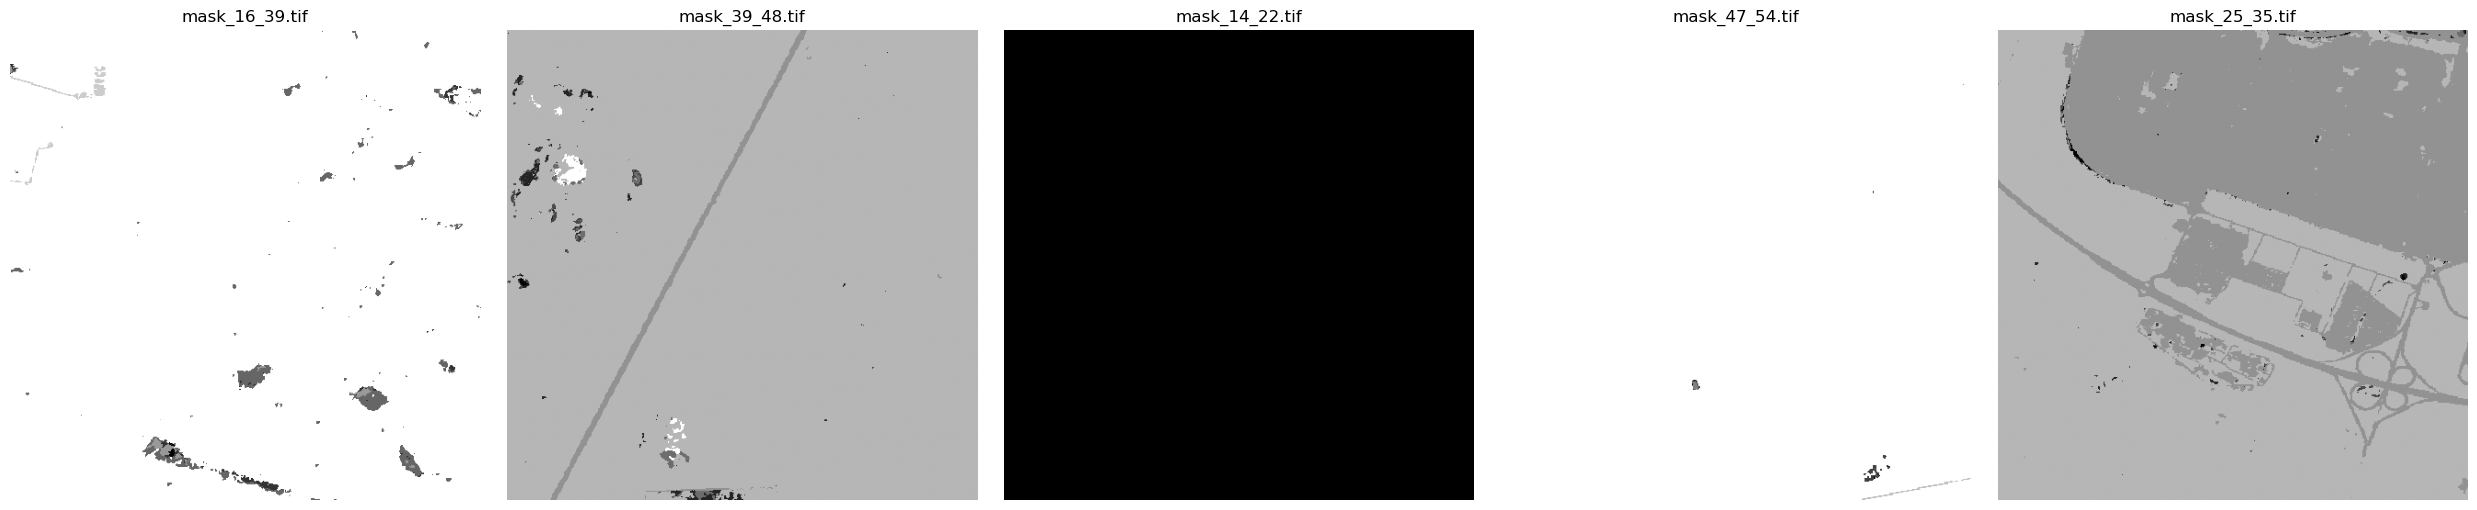

In [ ]:
visualize_random_tiffs("/Users/omaralshatti/Documents/KuwaitRaster/Dataset/tiles/imagenet_full_size/061417/train/class", n=5, rgb_bands=(0,1,2))
